In [4]:
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
# import statsmodels.api as sm
import csv
from scipy.stats import poisson
import itertools
import collections
import seaborn as sns
from scipy import stats
import FACSus as fs
from sklearn import preprocessing
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display
sns.set(style="whitegrid")
%cd /gpfs3/well/ansari/users/gjx698/boson
# %cd ..

/gpfs3/well/ansari/users/gjx698/boson


In [4]:
df = pd.read_csv("boson_vcf/results/all/CD3+iNKT+.baseline.gwas.txt", sep = ' ').dropna()
df['p'] = df['p'].astype(float)
df = df.sort_values("p").head(10)
df

,chr,ID,pos,alt,add,sample_size,beta,SE,p
4117554,11,rs550460,17902129,A,ADD,389,0.9671,5.865,9.933000e-09
4209864,11,rs7109894,57230175,C,ADD,389,-1.0130,-5.794,1.470000e-08
4209865,11,rs721607,57230358,C,ADD,389,-0.9890,-5.616,3.829000e-08
4209873,11,rs35099041,57234743,A,ADD,389,-1.0110,-5.570,4.913000e-08
4209872,11,rs746886,57234637,A,ADD,389,-0.9988,-5.506,6.863000e-08
4209868,11,rs2282623,57234352,T,ADD,389,-0.9733,-5.398,1.204000e-07
4209869,11,rs2282624,57234437,C,ADD,389,-0.9074,-5.147,4.303000e-07
4117502,11,rs537393,17873184,A,ADD,389,0.8547,5.053,6.828000e-07
4117524,11,rs547935,17884747,T,ADD,389,0.8749,5.024,7.892000e-07
4465272,12,rs33157,30835043,T,ADD,389,-1.6010,-4.994,9.109000e-07


# Reading Baseline FACS data, Filtering outliers, and Generating phenotype files:

In [2]:
def get_phe(col, df, save_name, plot = False, save_plot = False, save_path_plot = None, save_phe = False, save_path_phe = None):
    if save_plot and save_path_plot is None:
        save_path_plot = "graphs/facs-host/baseline/strip." + save_name + ".png"
    if save_phe and save_path_phe is None:
        save_path_phe = "boson_vcf/phenotypes/" + save_name + ".txt"
    tmp = fs.sanity_check_filter4(df, col, plot = plot, save = save_plot, save_path = save_path_plot)
    fs.get_phenotype(tmp, col, save = save_phe, save_path = save_path_phe)

In [3]:
# Read dfs and merge
df1 = pd.read_csv('facs/Baseline/Panel1_Baseline.csv', sep = ',', dtype = {'Patient ID': 'str'})
df2 = pd.read_csv('facs/Baseline/Panel2_Baseline.csv', sep = ',', dtype = {'Patient ID': 'str'})
df3 = pd.read_csv('facs/Baseline/Panel3_Baseline.csv', sep = ',', dtype = {'Patient ID': 'str'})
df4 = pd.read_csv('facs/Baseline/Panel4_Baseline.csv', sep = ',', dtype = {'Patient ID': 'str'})
df5 = pd.read_csv('facs/Baseline/Panel5_Baseline.csv', sep = ',', dtype = {'Patient ID': 'str'})
df1.iloc[:,1:-9] = df1.iloc[:,1:-9].apply(pd.to_numeric)
df1 = df1.drop(columns = ['Azim data.SUBJID'])
df2.iloc[:, 1:] = df2.iloc[:, 1:].apply(pd.to_numeric)
df3.iloc[:, 1:] = df3.iloc[:, 1:].apply(pd.to_numeric)
df4.iloc[:, 1:] = df4.iloc[:, 1:].apply(pd.to_numeric)
df5.iloc[:, 1:] = df5.iloc[:, 1:].apply(pd.to_numeric)

dfs = [df1, df2, df3, df4, df5]
new_dfs = [df1.copy(), df2.copy(), df3.copy(), df4.copy(), df5.copy()]
for i in range(5):
    new_columns = [dfs[i].columns[0]] + [col + '_panel' + str(i+1) for col in dfs[i].columns[1:]]
    new_dfs[i].columns = new_columns
tmp = pd.merge(new_dfs[0], new_dfs[1], on = 'Patient ID')
tmp = pd.merge(tmp, new_dfs[2], on = 'Patient ID')
tmp = pd.merge(tmp, new_dfs[3], on = 'Patient ID')
df = pd.merge(tmp, new_dfs[4], on = 'Patient ID')
df = df.dropna()
# df['Patient ID'] = 'BOSON' + df['Patient ID']

In [4]:
# df3 = fs.sanity_check_filter(df3, ['CD4+ TEMRA CD27- CD127+', 'CD4+ TEMRA CD27+ CD127+', 'CD4+ TEMRA CD27+ CD127-', 'CD4+ TEMRA CD27- CD127-'], 
#                           'CD4 TEMRA CD27 CD127')
# df3 = fs.sanity_check_filter(df3, 
#                           ['CD4+ TEM CD27- CD127+', 'CD4+ TEM CD27+ CD127+', 'CD4+ TEM CD27+ CD127-', 'CD4+ TEM CD27- CD127-'],
#                          'CD4 TEM CD27 CD127')
# df3 = fs.sanity_check_filter(df3, 
#                           ['CD4+ TCM CD27- CD127+', 'CD4+ TCM CD27+ CD127+', 'CD4+ TCM CD27+ CD127-', 'CD4+ TCM CD27- CD127-'],
#                          'CD4 TCM CD27 CD127')
# df3 = fs.sanity_check_filter(df3, 
#                           ['CD4+ Naïve CD27- CD127+', 'CD4+ Naïve CD27+ CD127+', 'CD4+ Naïve CD27+ CD127-', 'CD4+ Naïve CD27- CD127-'],
#                          'CD4 Naïve CD27 CD127')
# df3 = fs.sanity_check_filter(df3, 
#                           ['CD8+ TEMRA CD27- CD127+', 'CD8+ TEMRA CD27+ CD127+', 'CD8+ TEMRA CD27+ CD127-', 'CD8+ TEMRA CD27- CD127-'],
#                          'CD8 TEMRA CD27 CD127')
# df3 = fs.sanity_check_filter(df3, 
#                           ['CD8+ TEM CD27- CD127+', 'CD8+ TEM CD27+ CD127+', 'CD8+ TEM CD27+ CD127-', 'CD8+ TEM CD27- CD127-'],
#                          'CD8 TEM CD27 CD127')
# df3 = fs.sanity_check_filter(df3, 
#                           ['CD8+ TCM CD27- CD127+', 'CD8+ TCM CD27+ CD127+', 'CD8+ TCM CD27+ CD127-', 'CD8+ TCM CD27- CD127-'],
#                          'CD8 TCM CD27 CD127')
# df3 = fs.sanity_check_filter(df3, 
#                           ['CD8+ Naïve CD27- CD127+', 'CD8+ Naïve CD27+ CD127+', 'CD8+ Naïve CD27+ CD127-', 'CD8+ Naïve CD27- CD127-'],
#                          'CD8 Naïve CD27 CD127')
# df3 = fs.sanity_check_filter(df3, 
#                           ['CD4+ Naïve CCR7+ CD45RA+', 'CD4+ TEMRA CCR7- CD45RA+', 'CD4+ TCM CCR7+ CD45RA-', 'CD4+ TEM CCR7- CD45RA-'],
#                          'CD4 CCR7 CD45RA')
# df3 = fs.sanity_check_filter(df3, 
#                           ['CD8+ Naïve CCR7+ CD45RA+', 'CD8+ TEMRA CCR7- CD45RA+', 'CD8+ TCM CCR7+ CD45RA-', 'CD8+ TEM CCR7- CD45RA-'],
#                          'CD8 CCR7 CD45RA')
# df = sanity_check_filter2(df, ['Lymphocytes_panel' + str(i+1) for i in range(5)], 'Lymphocytes')
# df = sanity_check_filter2(df, ['Total live_panel' + str(i+1) for i in range(5)], 'Lymphocytes')
# df = sanity_check_filter2(df, ['Live_panel' + str(i+1) for i in range(5)], 'Lymphocytes')

/gpfs3/well/ansari/users/gjx698/BOSON_FACS/scripts/FACSus.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[newname] = df[cols].mean(axis=1)
/gpfs3/well/ansari/users/gjx698/BOSON_FACS/scripts/FACSus.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[newname] = df[cols].mean(axis=1)
/gpfs3/well/ansari/users/gjx698/BOSON_FACS/scripts/FACSus.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

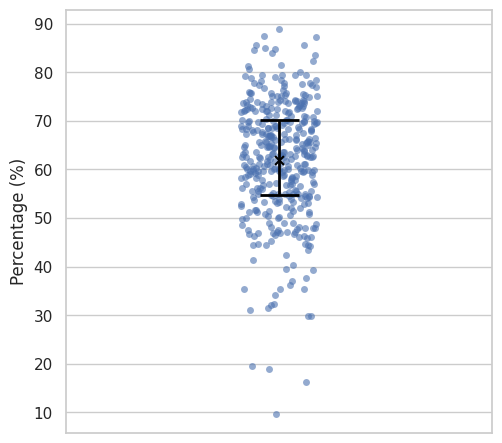

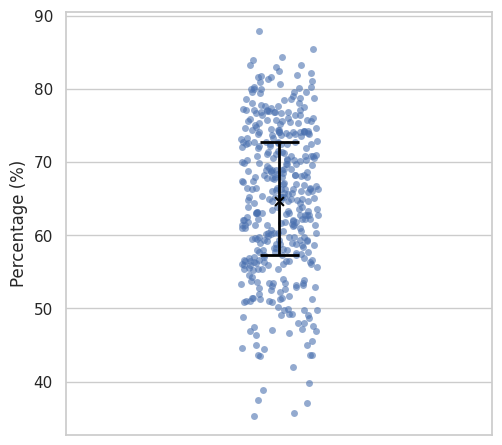

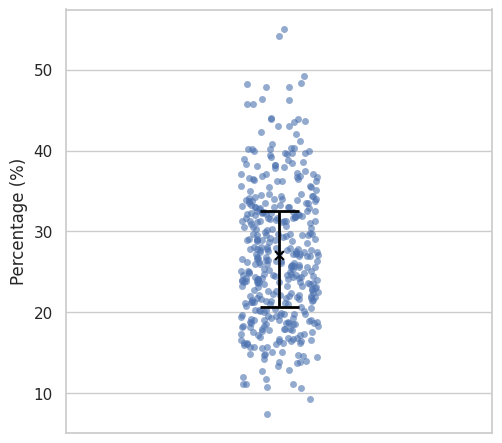

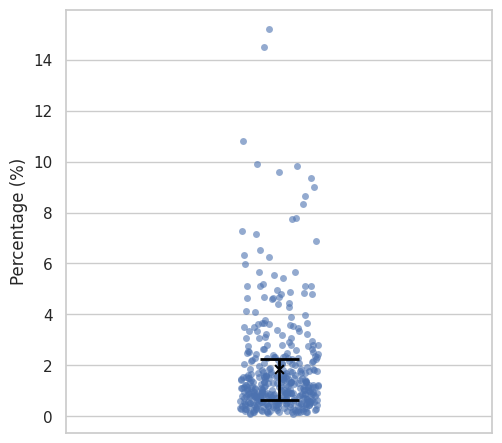

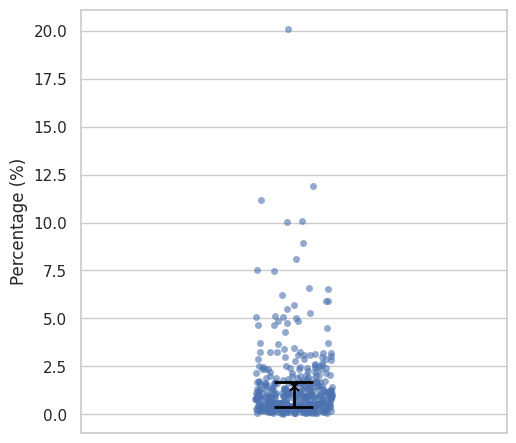

In [5]:
# Filtering 5 common markers
CD3 = fs.sanity_check_filter(df, ['CD3+_panel1', 'CD3-_panel1'], 'CD3')
CD3 = fs.sanity_check_filter2(CD3, ['CD3+_panel' + str(i+1) for i in range(5)], 'CD3+')
get_phe('CD3+', CD3, 'CD3+', plot = True, save_plot = True, save_phe = True)
CD4 = fs.sanity_check_filter2(df, ['CD3+/CD3+CD4+_panel' + str(i+1) for i in range(5)], 'CD3+CD4+')
get_phe('CD3+CD4+', CD4, 'CD3+CD4+', plot = True, save_plot = True, save_phe = True)
CD8 = fs.sanity_check_filter2(df, ['CD3+/CD3+CD8+_panel' + str(i+1) for i in range(5)], 'CD3+CD8+')
get_phe('CD3+CD8+', CD8, 'CD3+CD8+', plot = True, save_plot = True, save_phe = True)
CD161 = fs.sanity_check_filter3(df, 'CD3+/CD3+CD8+/CD8+CD161++', 'CD3+CD8+CD161++')
get_phe('CD3+CD8+CD161++', CD161, 'CD3+CD8+CD161++', plot = True, save_plot = True, save_phe = True)
Va72 = fs.sanity_check_filter3(df, 'CD3+/CD3+CD8+/CD8+CD161+Va7.2+', 'CD3+CD8+CD161+Va7.2+')
get_phe('CD3+CD8+CD161+Va7.2+', Va72, 'CD3+CD8+CD161+Va7.2+', plot = True, save_plot = True, save_phe = True)

/gpfs3/well/ansari/users/gjx698/BOSON_FACS/scripts/FACSus.py:75: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(5.5, 5.5))


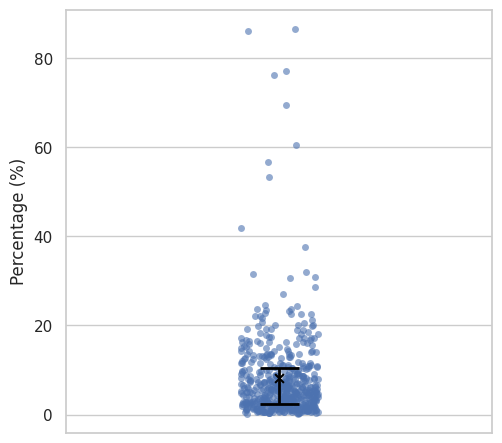

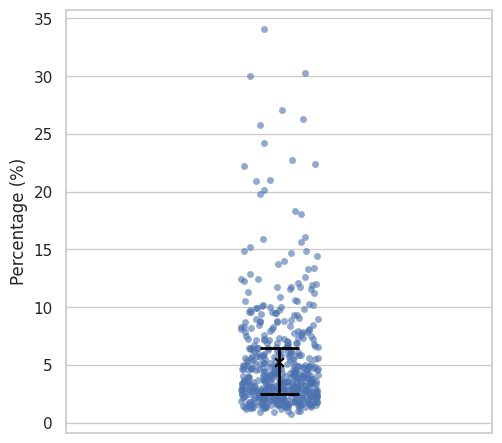

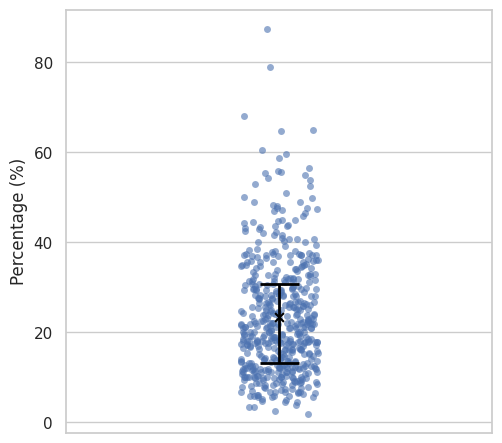

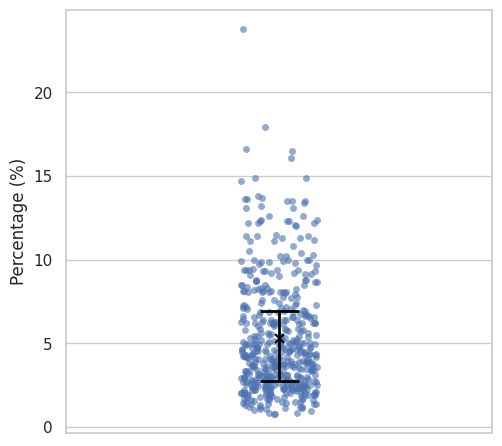

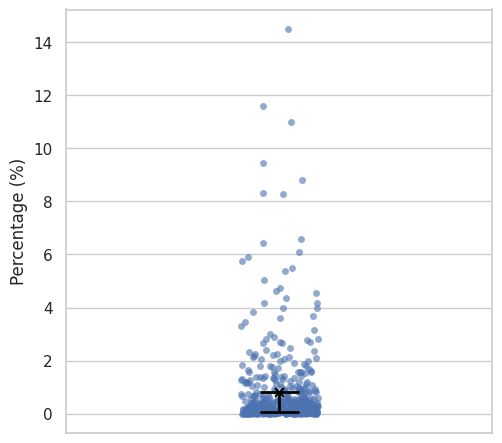

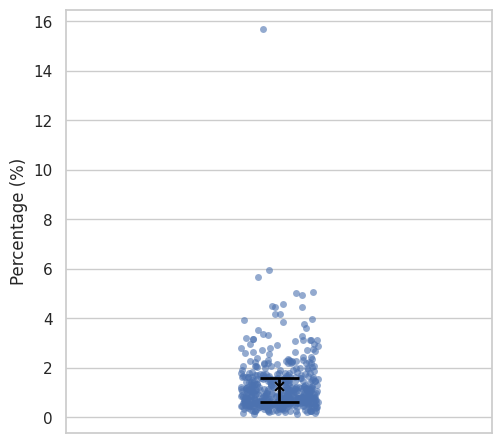

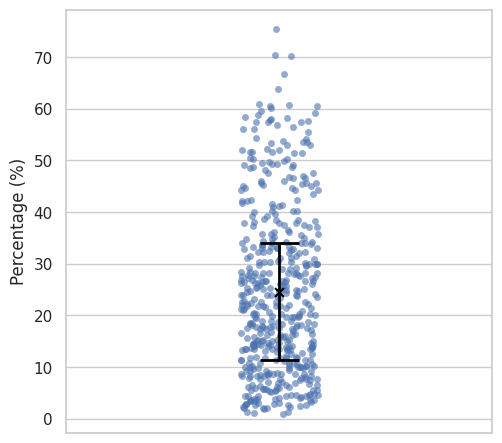

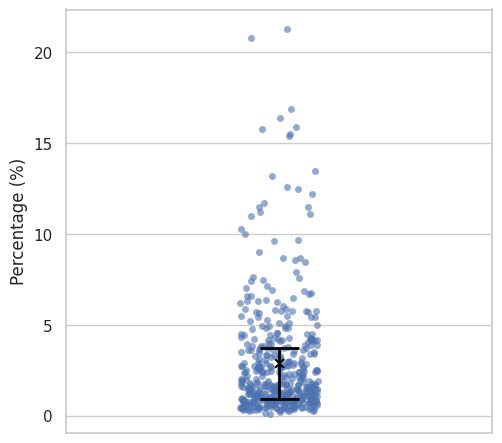

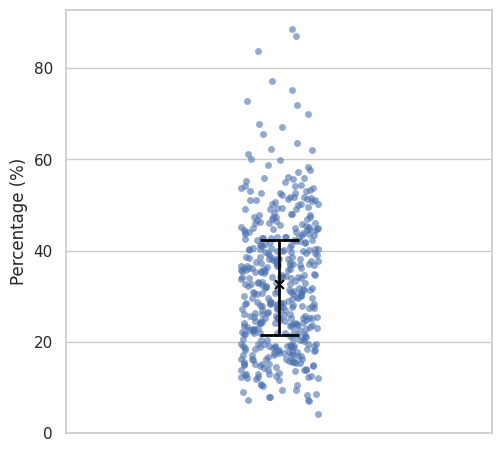

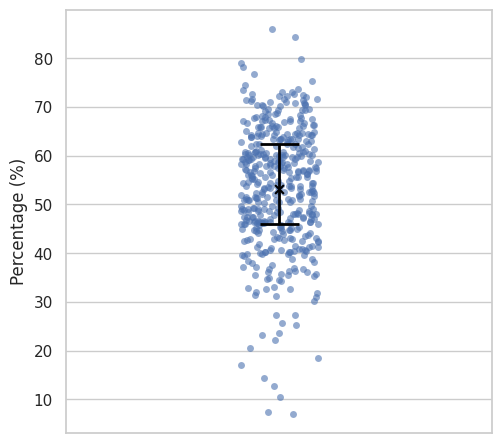

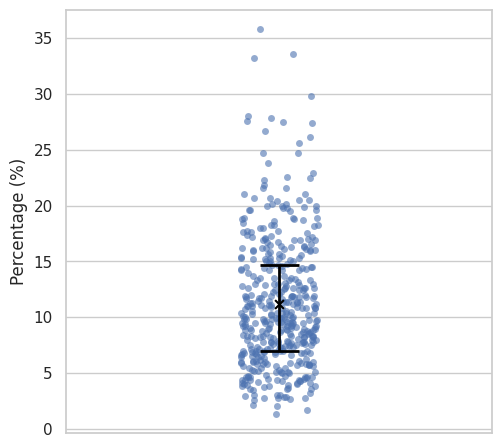

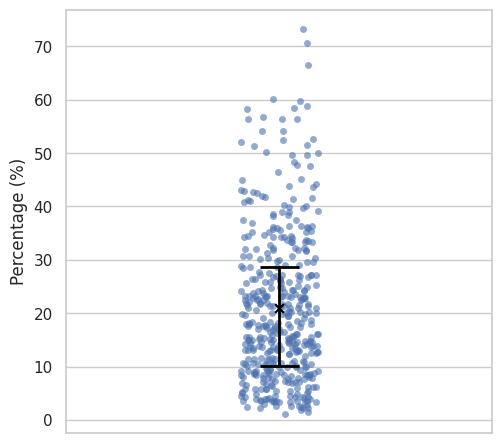

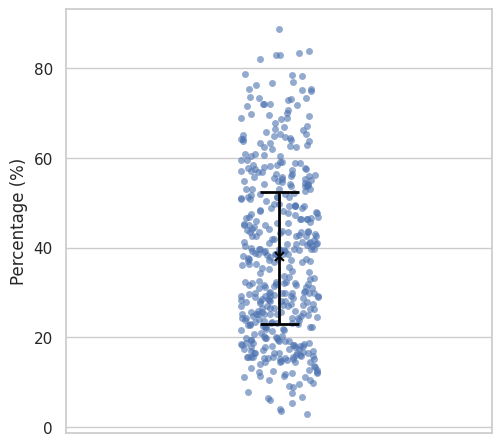

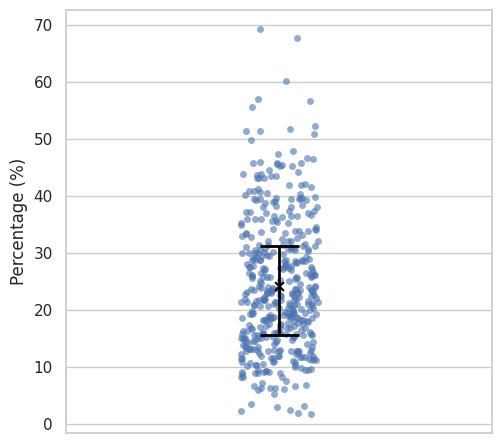

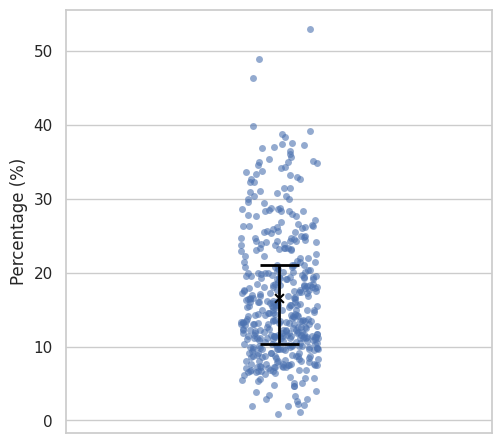

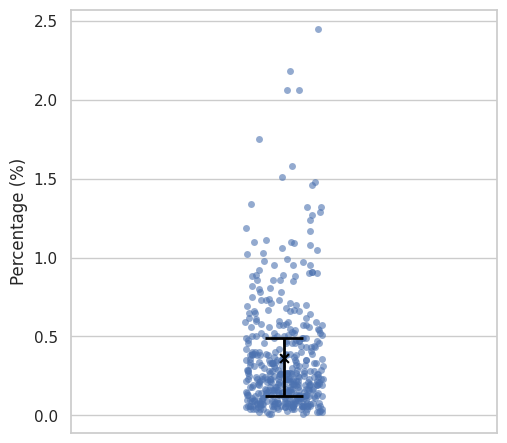

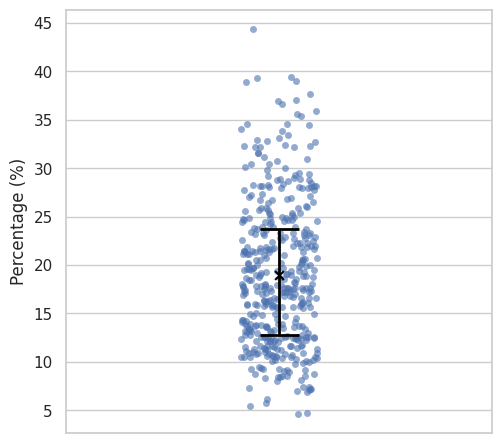

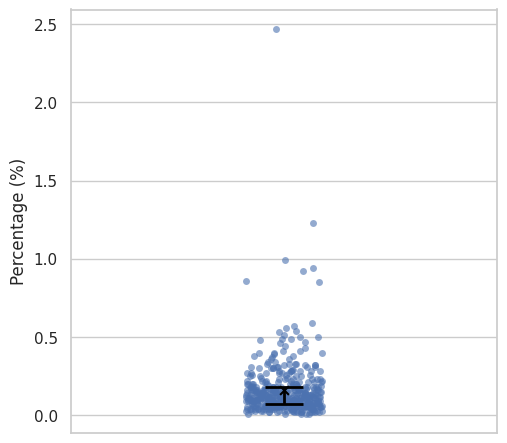

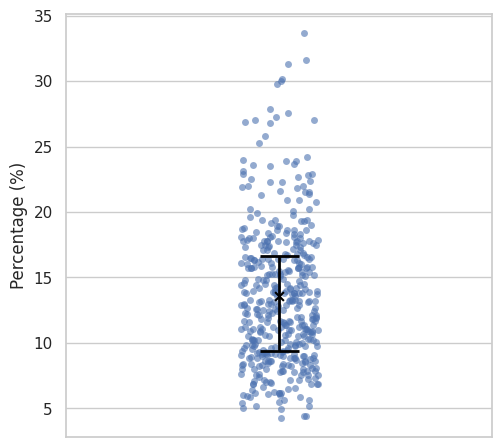

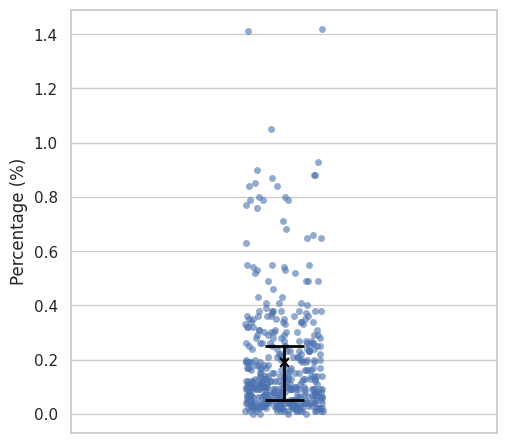

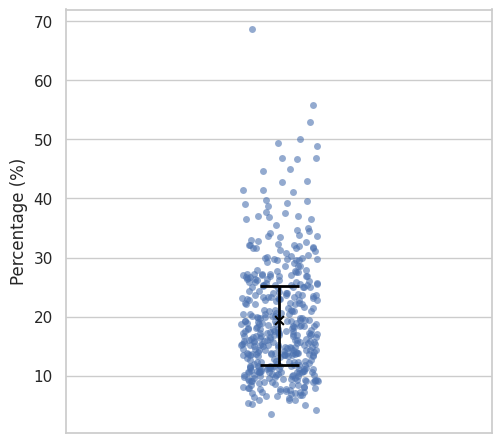

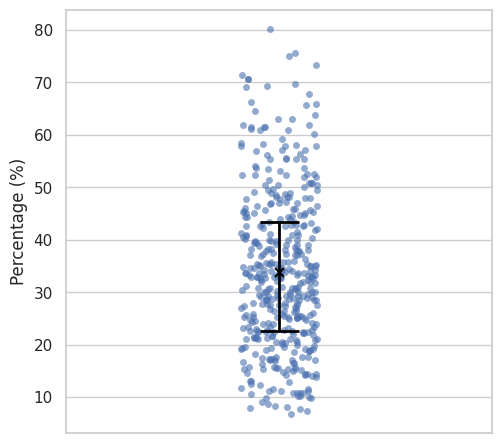

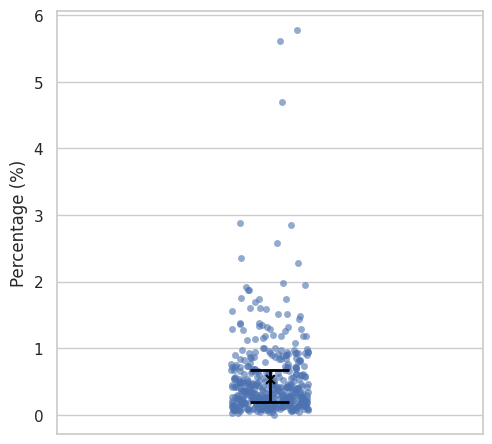

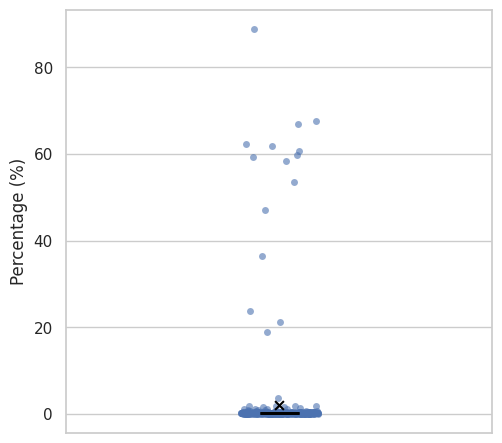

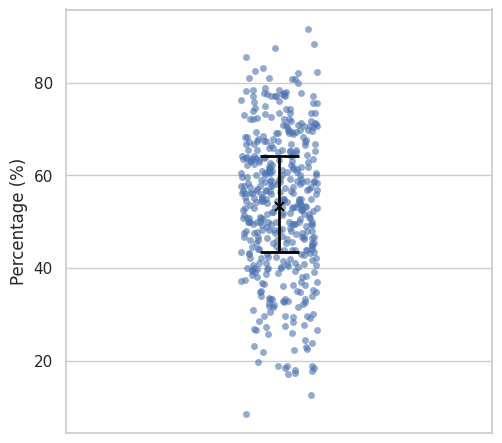

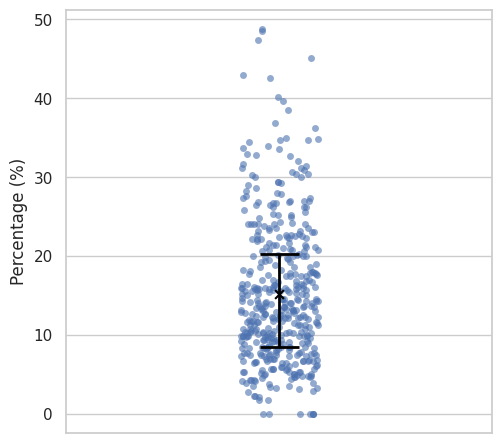

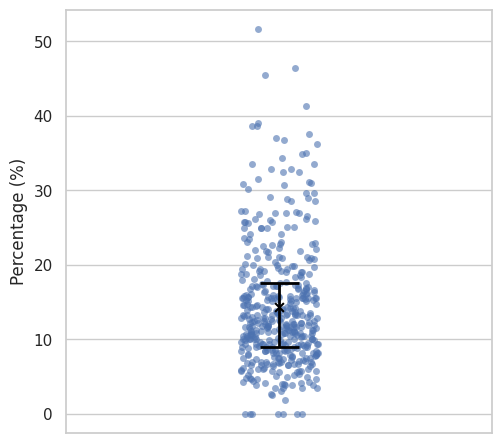

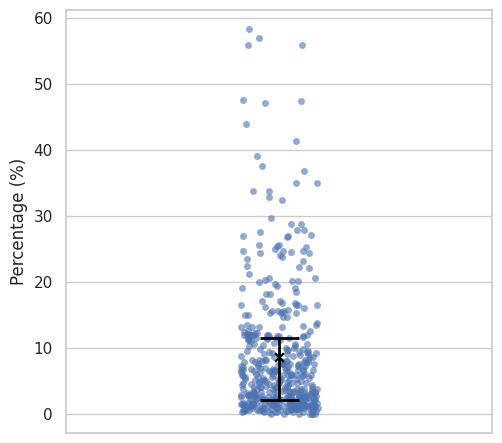

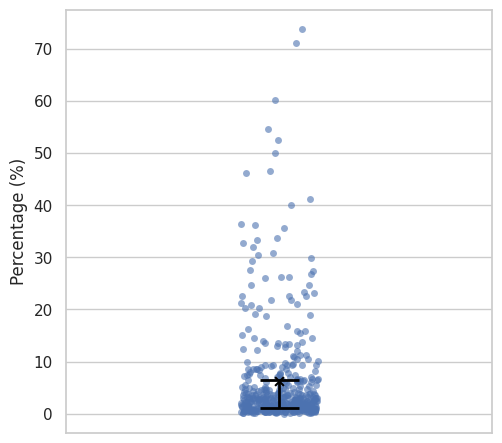

In [6]:
# Filtering each marker
get_phe('CD3+/CD3+CD8+CD57+', df1, 'CD3+CD57+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/DN', df1, 'CD3+DN', plot = True, save_plot = True, save_phe = True)
get_phe('CD3-/CD3-CD56+ total', df1, 'CD3-CD56+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD4+/CD4+CD38+', df2, 'CD3+CD4+CD38+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD4+/CD4+GzB+', df2, 'CD3+CD4+GzB+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD8+/CD8+ CD38+', df2, 'CD3+CD8+CD38+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD8+/CD8+ GzB+', df2, 'CD3+CD8+GzB+', plot = True, save_plot = True, save_phe = True)
get_phe('CD4+ TEMRA CCR7- CD45RA+', df3, 'CD3+CD4+CCR7-CD45RA+', plot = True, save_plot = True, save_phe = True)
get_phe('CD4+ Naïve CCR7+ CD45RA+', df3, 'CD3+CD4+CCR7+CD45RA+', plot = True, save_plot = True, save_phe = True)
get_phe('CD4+ TCM CCR7+ CD45RA-', df3, 'CD3+CD4+CCR7+CD45RA-', plot = True, save_plot = True, save_phe = True)
get_phe('CD4+ TEM CCR7- CD45RA-', df3, 'CD3+CD4+CCR7-CD45RA-', plot = True, save_plot = True, save_phe = True)
get_phe('CD8+ TEMRA CCR7- CD45RA+', df3, 'CD3+CD8+CCR7-CD45RA+', plot = True, save_plot = True, save_phe = True)
get_phe('CD8+ Naïve CCR7+ CD45RA+', df3, 'CD3+CD8+CCR7+CD45RA+', plot = True, save_plot = True, save_phe = True)
get_phe('CD8+ TEM CCR7- CD45RA-', df3, 'CD3+CD8+CCR7-CD45RA-', plot = True, save_plot = True, save_phe = True)
get_phe('CD8+ TCM CCR7+ CD45RA-', df3, 'CD3+CD8+CCR7+CD45RA-', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD4+/LAG3+', df4, 'CD3+CD4+LAG3+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD4+/PD1+', df4, 'CD3+CD4+PD1+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD4+/TIGIT+', df4, 'CD3+CD4+TIGIT+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD4+/Tim3+', df4, 'CD3+CD4+Tim3+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD8+/LAG3+', df4, 'CD3+CD8+LAG3+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD8+/PD1+', df4, 'CD3+CD8+PD1+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD8+/TIGIT+', df4, 'CD3+CD8+TIGIT+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+CD8+/Tim3+', df4, 'CD3+CD8+Tim3+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+ iNKT+', df5, 'CD3+iNKT+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+ iNKT+/iNKT+ CD4+', df5, 'CD3+iNKT+CD4+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+ iNKT+/iNKT+ CD8+', df5, 'CD3+iNKT+CD8+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+ PanGd+', df5, 'CD3+PanGd+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+ PanGd+ Vd1+', df5, 'CD3+PanGd+Vd1+', plot = True, save_plot = True, save_phe = True)
get_phe('CD3+/CD3+ PanGd+ Vd2+', df5, 'CD3+PanGd+Vd2+', plot = True, save_plot = True, save_phe = True)

In [ ]:
# save dfs
# df.to_csv('facs/Baseline/merged.csv', sep = ',', index = False)
# df.columns

# Prepare `covar.factor.txt` file for GWAS

In [2]:
def encode(x):
    if x in ['Cirrhosis', 'Male', 'Treatment-experienced', 'T/T']:
        return 1
    elif x in ['Absence of Cirrhosis', 'Female', 'Treatment-naive', 'C/T']:
        return 2
    elif x in ['C/C']:
        return 3
    else:
        return 0

In [5]:
df = pd.read_csv('boson_metadata/Boson_data.csv', sep = ',')
df['patient_id'] = 'BOSON' + df['patient_id'].astype(str)
vl = pd.read_csv('boson_metadata/boson.VL.csv', sep = ',')
vl['subid'] = 'BOSON' + vl['subid'].astype(str)
vl['Screening'] = np.log10(vl['Screening'])
vl = vl.rename(columns = {'subid': 'FID', 'Screening': 'VL'})
vl = vl[['FID', 'VL']]
PCs = pd.read_csv('boson_original_files/PCs.txt', header = None, sep = ' ')
PCs.columns = ['FID', 'IID'] + ['PC' + str(i) for i in range(1,21)]
PCs = pd.merge(PCs, df[['patient_id', 'gender', 'age', 'IL28B', 'PriorTreatment', 'Cirrohosis']], left_on = 'FID', right_on = 'patient_id').sort_values(by = 'FID')
PCs = PCs.drop(columns = ['patient_id'] + ['PC' + str(i) for i in range(11, 21)])
PCs['gender'] = PCs['gender'].apply(encode)
PCs['IL28B'] = PCs['IL28B'].apply(encode)
PCs['PriorTreatment'] = PCs['PriorTreatment'].apply(encode)
PCs['Cirrohosis'] = PCs['Cirrohosis'].apply(encode)
all = pd.merge(PCs, vl, on = 'FID')
all.to_csv('boson_vcf/covar.all.txt', sep = ' ', index = False, header = False, float_format='%.6f')

In [26]:
df[col].unique()

array(['T/T', 'C/C', 'C/T', nan], dtype=object)

In [22]:
col = 'VL'
ary = all[col].dropna().values
print(np.mean(ary))
print(np.min(ary), np.max(ary))

6.269987342160554
4.27415784926368 7.6148972160331345


In [23]:
col = 'IL28B'
print(all[col].value_counts())

print(all[col].value_counts()/all.shape[0])

2    261
3    207
1     72
0      2
Name: IL28B, dtype: int64
2    0.481550
3    0.381919
1    0.132841
0    0.003690
Name: IL28B, dtype: float64


# Merge boson data to a single file

In [ ]:
VL = pd.read_csv('boson_metadata/boson.VL.csv', sep = ',')
VL['FID'] = 'BOSON' + VL['subid'].astype(str)
VL = VL.drop(columns = 'subid')
cols = VL.columns.tolist()
VL = VL[[cols[-1]] + cols[:-1]]

df = pd.read_csv('boson_metadata/Boson_data.csv', sep = ',')
df['patient_id'] = 'BOSON' + df['patient_id'].astype(str)
df = df.rename(columns = {'patient_id': 'FID'})
df = pd.merge(df, VL, on = 'FID')
df.to_csv('boson_metadata/boson.data.merged.txt', sep = ' ', index = False, header = True)

# Plot PCs

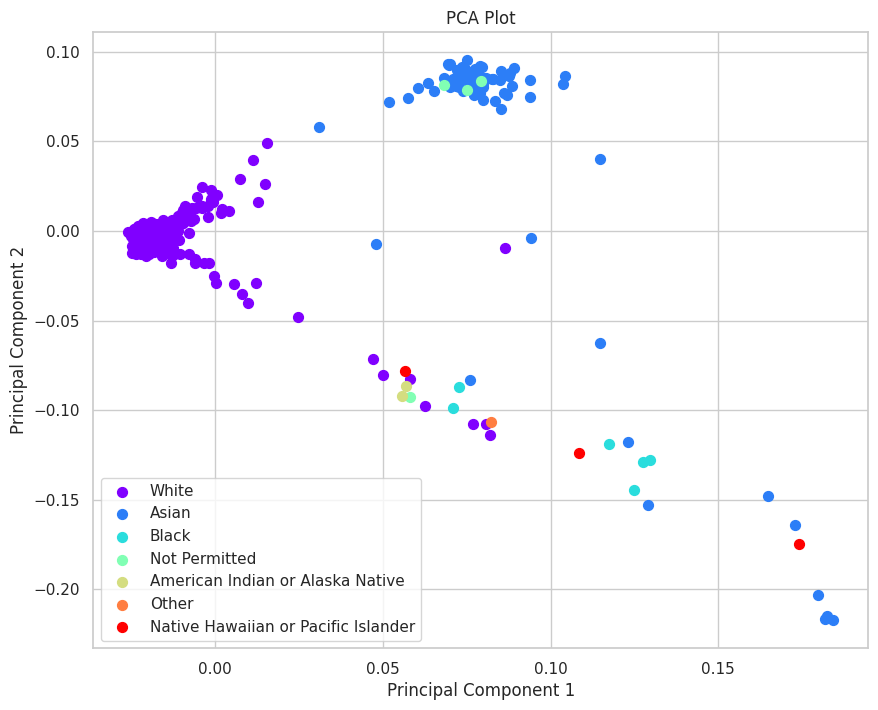

In [6]:
PCs = pd.read_csv('boson_vcf/covar.factor.txt', sep = ' ', header = None)
PCs.columns = ['FID', 'IID', 'sex', 'age'] + ['PC' + str(i) for i in range(1,11)]

df = pd.read_csv('boson_metadata/Boson_data.csv', sep = ',')
df['patient_id'] = 'BOSON' + df['patient_id'].astype(str)

pca = pd.merge(PCs[['FID'] + ['PC' + str(i) for i in range(1,5)]], df[['patient_id', 'Race']], left_on = 'FID', right_on = 'patient_id').drop(columns = 'patient_id')

plt.figure(figsize=(10, 8))

labels = pca['Race']
targets = labels.unique()
colors = plt.cm.rainbow(np.linspace(0, 1, len(targets)))
for target, color in zip(targets, colors):
    indices_to_keep = labels == target
    plt.scatter(
        pca.loc[indices_to_keep, 'PC1'],
        pca.loc[indices_to_keep, 'PC2'],
        color=color,
        label=target,
        s=50,
    )
plt.legend()

plt.title('PCA Plot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
# plt.show()
plt.savefig('graphs/facs-host/PCA.png', dpi = 300, bbox_inches = "tight")

# Markers Correlation Plot

In [ ]:
df['CD3+'] = df[['CD3+_panel' + str(i+1) for i in range(5)]].mean(axis = 1)
df['CD4+'] = df[['CD3+/CD3+CD4+_panel' + str(i+1) for i in range(5)]].mean(axis = 1)
df['CD8+'] = df[['CD3+/CD3+CD8+_panel' + str(i+1) for i in range(5)]].mean(axis = 1)
df['CD161++'] = df[['CD3+/CD3+CD8+/CD8+CD161++_panel1', 'CD3+/CD3+CD8+/CD8+CD161++_panel2']].mean(axis = 1)
df['Va7.2+'] = df[['CD3+/CD3+CD8+/CD8+CD161+Va7.2+_panel1', 'CD3+/CD3+CD8+/CD8+CD161+Va7.2+_panel2']].mean(axis = 1)
markers = [col for col in df.columns if 'CD' in col] + ['Va7.2+']
tmp = df[markers]
tmp = tmp.drop(columns = ['CD3+_panel' + str(i+1) for i in range(5)] + ['CD3+/CD3+CD4+_panel' + str(i+1) for i in range(5)] + 
              ['CD3+/CD3+CD8+_panel' + str(i+1) for i in range(5)] + ['CD3+/CD3+CD8+/CD8+CD161++_panel1', 'CD3+/CD3+CD8+/CD8+CD161++_panel2'] + 
              ['CD3+/CD3+CD8+/CD8+CD161+Va7.2+_panel1', 'CD3+/CD3+CD8+/CD8+CD161+Va7.2+_panel2'])

correlation_matrix = tmp.corr()
mask = np.tril(np.ones_like(correlation_matrix))
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', xticklabels=False, yticklabels=False, linewidths=0)
plt.title('Correlations between markers at Baseline')
plt.savefig("graphs/facs-host/markers_corr.png", dpi = 300, bbox_inches = "tight")

# FACS Pairplot

In [ ]:
sns.pairplot(df[['CD3+_panel' + str(i+1) for i in range(5)]], kind = 'scatter', corner = True)
plt.savefig('boson_vcf/graphs/CD3+_pairwise.png', dpi = 300, bbox_inches = 'tight')

# Parse Baseline GWAS results

In [ ]:
markers = pd.read_csv('boson_vcf/markers.txt', header = None).rename(columns = {0: 'marker'})
markers = markers.marker.to_list()
for i in markers:
    fs.parse_plink('boson_vcf/results/' + i + '.assoc.linear', True, 'boson_vcf/results/' + i + '.baseline.gwas.txt')

# Combine Baseline GWAS results

In [3]:
markers = pd.read_csv('boson_vcf/markers.txt', header = None).rename(columns = {0: 'marker'})
markers = markers.marker.to_list()
for i in markers:
    fs.combine_gwas_res(i, indir = "/gpfs3/well/ansari/users/gjx698/BOSON_FACS/graphs/facs-host/baseline/all/", save = True)